Company XYZ started a subscription model in January, 2015. You get hired as a ﬁrst data scientist at the end of August and, as a ﬁrst task, you are asked to help executives understand how the subscription model is doing.

Therefore, you decide to pull data from all the users who subscribed in January and see, for each month, how many of them unsubscribed. In particular, your boss is interested in:

* A model that predicts monthly retention rate for the diﬀerent subscription price points
* Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?
* How do user country and source aﬀect subscription retention rate? How would you use these ﬁndings to improve the company revenue?

# Index
* [Load the data](#Load-the-data)
* [Answer questions 1](#Answer-question-1)
    * [calculate total number by the end of each billing cycle for each 'monthly-cost'](#calculate-total-number-by-the-end-of-each-billing-cycle-for-each-'monthly-cost')
    * [fit Linear Regression model](#fit-Linear-Regression-model)
    * [predict on billing cycles from 9~12](#predict-on-billing-cycles-from-9~12)
* [Answer question 2](#Answer-question-2)
* [Answer question 3](#Answer-question-3)
    * [how country affects retention rate?](#how-country-affects-retention-rate?)
    * [how source affects retention rate?](#how-source-affects-retention-rate?)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression
%matplotlib inline

## Load the data

In [2]:
subscriptions = pd.read_csv("subscription.csv",index_col='user_id')

# 'subscription_signup_date' is always Jan, 2015 in this table. useless, so delete it
del subscriptions['subscription_signup_date']

# rename some long column name to short ones, which is easier to read
subscriptions.rename(columns={'subscription_monthly_cost':'monthly_cost',
                              'billing_cycles':'bill_cycles'},inplace=True)

In [3]:
# check the data, have a feeling about it
subscriptions.sample(10)

,monthly_cost,country,source,bill_cycles,is_active
user_id,,,,,
160433,49,France,ads,2,0
216395,29,UK,ads,8,1
188261,49,UK,ads,1,0
166327,29,UK,seo,1,0
445677,49,China,ads,1,0
261087,49,Italy,ads,1,0
67364,49,India,ads,1,0
100639,49,Spain,ads,1,0
32765,49,US,seo,1,0


## Answer question 1
A model that predicts monthly retention rate for the diﬀerent subscription price points

### calculate total number by the end of each billing cycle for each 'monthly cost'

In [4]:
count_by_cost = subscriptions.groupby('monthly_cost').apply(lambda df: df.bill_cycles.value_counts()).unstack()
# for index 'n', the value is the #people who paid 'n' billing cycles
count_by_cost

,1,2,3,4,5,6,7,8
monthly_cost,,,,,,,,
29,57441,21818,12037,7787,5505,4136,3111,34527
49,185145,53296,21690,11288,6727,4405,3173,14673
99,44788,4724,1471,678,399,226,156,799


In [5]:
# for each row in 'count_by_cost', we perform a reverse cumsum to get the #people by the end of each billing cycles
total_by_cost = count_by_cost.apply(lambda s: s.iloc[::-1].cumsum().iloc[::-1],axis=1).transpose()
total_by_cost

monthly_cost,29,49,99
1,146362,300397,53241
2,88921,115252,8453
3,67103,61956,3729
4,55066,40266,2258
5,47279,28978,1580
6,41774,22251,1181
7,37638,17846,955
8,34527,14673,799


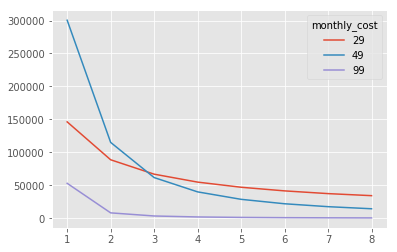

In [6]:
total_by_cost.plot()

### fit Linear Regression model
from above plot, we can draw following conclusions:
1. for each 'monthly_cost', there are only 8 samples.
    * ** complex model will overfit on samll dataset, so I decide to use a simple regression model - Linear Regression **
2. the remaining #subscribers by the end of each billing cycles has a nonlinear relationship with #billing_cycles
    * ** so I need to include some nonlinear transformation of 'billing_cycles' **
3. by no means, the target, #subscribers should be non-negative
    * <span style='color:orange;font-weight:bold;font-size:1.5em'>so I cannot fit on original target, i.e., '#subscribers at the end of each billing cycle', but on log(#subscribers).</span>
    * <span style='color:orange;font-weight:bold;font-size:1.5em'>then after obtaining the fitted value, we transform back to '#subscribers' by exp(), which can guarantee the result is always positive</span>

In [7]:
def make_time_features(t):
    """
    three features:
    1. t: #cycles
    2. t-square: square of #cycles
    3. logt: log(#cycles)
    """
    return pd.DataFrame({'t': t,'logt': np.log(t),'tsquare':t*t },index = t)

def fit_linear_regression(s):
    """
    target:
    log(s): s is #subscribers left by the end of each billing cycle
    do this transformation, to guarantee that, after tranforming back, the fitted result is always positive
    """
    X = make_time_features(s.index)
    return LinearRegression().fit(X,np.log(s))

In [8]:
lr_by_cost = total_by_cost.apply(fit_linear_regression,axis=0)

### predict on billing cycles from 9~12

because
1. <span style='color:orange;'>there are so few examples (only 8) for each model. we cannot afford to split out a separate test set, which will further reduce the data used for training</span>
2. <span style='color:orange;'>the question is predicting near future, cycles from 9 to 12, which I assume there is no significant difference from our training data.</span>

due to above two considerations, I don't use normal cross validation to check how my model fits, but just plot the true values and my predictions to ** visualize ** how my model fits.

In [9]:
allt = np.arange(1,13)
Xwhole = make_time_features(allt)
Xwhole

,logt,t,tsquare
1,0.000000,1,1
2,0.693147,2,4
3,1.098612,3,9
4,1.386294,4,16
5,1.609438,5,25
6,1.791759,6,36
7,1.945910,7,49
8,2.079442,8,64
9,2.197225,9,81
10,2.302585,10,100


In [10]:
# call each cost's model to fit on above features
predicts = lr_by_cost.apply(lambda lr: pd.Series(lr.predict(Xwhole),index=allt)).transpose()
predicts = predicts.applymap(np.exp)

In [11]:
predicts

monthly_cost,29,49,99
1,146289.043583,301551.603773,52816.489536
2,89078.661927,113569.323151,8700.570325
3,67048.510837,62560.448086,3678.850952
4,54997.715283,40592.309531,2210.169591
5,47259.987332,28988.345871,1567.465186
6,41802.132010,22106.115832,1208.305347
7,37703.792361,17713.678002,968.806877
8,34484.309114,14771.777457,786.979952
9,31866.862280,12740.560957,636.784748
10,29680.233950,11317.105659,507.336931


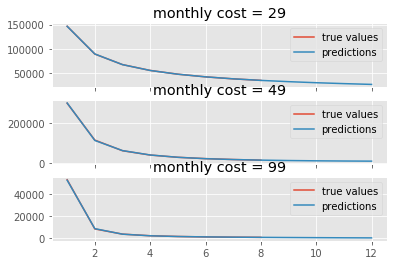

In [12]:
fig,axes = plt.subplots(3,1,sharex=True)
monthly_costs = [29,49,99]
for index,cost in enumerate(monthly_costs):
    ax = axes[index]
    total_by_cost.loc[:,cost].plot(ax = ax,label='true values')
    predicts.loc[:,cost].plot(ax=ax,label='predictions')
    ax.legend(loc='best')
    ax.set_title('monthly cost = {}'.format(cost))
plt.rc('figure',figsize=(5,10))

combine the real values and predictions together to check how the fits going

In [13]:
pd.merge(total_by_cost,predicts,how='right',left_index=True,right_index=True,suffixes = ('_true','_pred'))

monthly_cost,29_true,49_true,99_true,29_pred,49_pred,99_pred
1,146362.0,300397.0,53241.0,146289.043583,301551.603773,52816.489536
2,88921.0,115252.0,8453.0,89078.661927,113569.323151,8700.570325
3,67103.0,61956.0,3729.0,67048.510837,62560.448086,3678.850952
4,55066.0,40266.0,2258.0,54997.715283,40592.309531,2210.169591
5,47279.0,28978.0,1580.0,47259.987332,28988.345871,1567.465186
6,41774.0,22251.0,1181.0,41802.132010,22106.115832,1208.305347
7,37638.0,17846.0,955.0,37703.792361,17713.678002,968.806877
8,34527.0,14673.0,799.0,34484.309114,14771.777457,786.979952
9,NaN,NaN,NaN,31866.862280,12740.560957,636.784748
10,NaN,NaN,NaN,29680.233950,11317.105659,507.336931


## Answer question 2
Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

In [14]:
predicts.loc[12,:]/predicts.loc[1,:]

monthly_cost
29    0.179014
49    0.031984
99    0.005644
dtype: float64

## Answer question 3
How do user country and source aﬀect subscription retention rate? How would you use these ﬁndings to improve the company revenue?

In [15]:
def calc_retention_rate(s):
    """
    input: 
        s: n-th value is #subscribers who paid 'n' cycles
    return:
        retention rate by the end of each cycle
    """
    r = s.iloc[::-1].cumsum().iloc[::-1]
    return r/r.iloc[0]

def retention_rate_by(colname):
    """
    step 1. group subscribers based on certain column, e.g., country or source
    step 2. for each group, count #subscribers who paid 'n' cycles
    step 3. for each group, calculate retention rate for each cycle
    """
    counts = subscriptions.groupby(colname).apply(lambda df: df.bill_cycles.value_counts()).unstack()
    return counts.apply(calc_retention_rate, axis=1).transpose()

### how country affects retention rate?

In [16]:
retention_rate_by_country = retention_rate_by('country')
retention_rate_by_country

country,China,France,Germany,India,Italy,Spain,UK,US
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.514831,0.334946,0.451284,0.446728,0.341684,0.339098,0.458938,0.456509
3,0.402777,0.177732,0.278411,0.326962,0.179502,0.178985,0.285133,0.284255
4,0.360426,0.119004,0.195910,0.284527,0.119914,0.119879,0.198067,0.198853
5,0.336274,0.088479,0.146474,0.261603,0.090015,0.088648,0.149421,0.149284
6,0.319856,0.069935,0.115151,0.246736,0.071135,0.070065,0.117356,0.117398
7,0.307084,0.058341,0.093868,0.234847,0.057523,0.057617,0.095735,0.094875
8,0.295453,0.049688,0.078465,0.225769,0.048695,0.048503,0.079494,0.078981


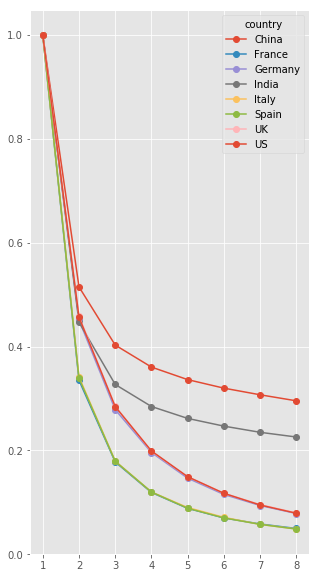

In [17]:
retention_rate_by_country.plot(marker='o')

In [18]:
# rank countries by August's retention rate
retention_rate_by_country.iloc[-1,:].sort_values(ascending=False)

country
China      0.295453
India      0.225769
UK         0.079494
US         0.078981
Germany    0.078465
France     0.049688
Italy      0.048695
Spain      0.048503
Name: 8, dtype: float64

based on above result, we can divide coutries into 3 classes:
1. customers from China and Indian are most loyal ones. 
    * not only retention rate is high, but also the 'dropping rate' is the slowest
    * this may be because the good economic situations in these two countries, and also because rich people in these two countries love buying foreign products to show their 'social class'.
    * to increase the revenue, ** we should keep tight touch to customers in China and Indian. for examples, sending coupons to them from time to time.**
2. UK, US, Germany has medium 'retention rate'
3. France, Italy, Spain has the lowest 'retention rate'
    * maybe because the poor economic conditions in these countries
    * ** we may consider to lower the 'monthly cost' in these countries, to keep more customers in subscription **

### how source affects retention rate?

In [19]:
retention_rate_by_source = retention_rate_by('source')
retention_rate_by_source

source,ads,friend_referral,seo
1,1.000000,1.000000,1.000000
2,0.388873,0.699443,0.562395
3,0.222094,0.617038,0.420012
4,0.152607,0.561282,0.337594
5,0.114959,0.519854,0.286254
6,0.092043,0.487596,0.247877
7,0.076756,0.461110,0.218680
8,0.066237,0.436507,0.194475


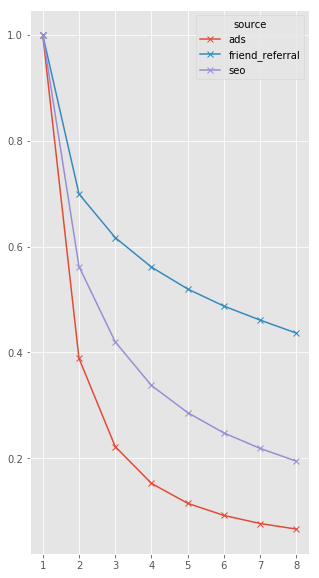

In [20]:
retention_rate_by_source.plot(marker='x')

from above result, we can see that subscribers from 'friend_referral' are the loyalest, much more loyal then subscribers from advertisement and search engine. 

To improve the revenue, ** we can launch some program to improve 'user referral'. for example, current subscribers can invite new users to subscribe. if your friends subscribe, you get rewarded with a certain amount of money or credit.**